In [110]:
import camb
import numpy as np
from scipy.integrate import quad
from scipy.special import spherical_jn
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt

In [111]:
def P_r(H0=67.5, ombh2=0.022, omch2=0.12, omk=0, TCMB=2.725, w=-1):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, TCMB=TCMB, omk=omk)
    pars.set_dark_energy(w=w)
    pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
    pars.set_matter_power(redshifts=[0], kmax=5.0)
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=5.0, npoints=200)
    return kh, pk[0]

def xi_l(s, l, kh, pk):
    real_integrand = lambda k: (np.real(1j**l) * (k**2)) * spherical_jn(l, k * s) * np.interp(k, kh, pk) / (2 * np.pi**2)
    img_integrand = lambda k: (np.imag(1j**l) * (k**2)) * spherical_jn(l, k * s) * np.interp(k, kh, pk) / (2 * np.pi**2)
    real_result, _ = quad(real_integrand, kh[0], kh[-1])
    img_result, _ = quad(img_integrand, kh[0], kh[-1])
    final_result = real_result + img_result
    return final_result

def H(a, Omega_m, Omega_DE, H0=67.5):
    H = H0 * np.sqrt(Omega_m * a**(-3) + Omega_DE + (1 - Omega_m - Omega_DE) * a**(-2))
    return H

def D(a, Omega_m, Omega_DE, H0=67.5):
    prod = (5/2) * Omega_m * (H(a, Omega_m, Omega_DE, H0) / H0)
    def integrand(a_prime):
        integrand = 1 / (a_prime * H(a_prime, Omega_m, Omega_DE, H0) / H0)**3
        return integrand
    integral, _ = quad(integrand, 0, a)
    result = prod * integral
    return result

def f_z(a, Omega_m, Omega_DE, H0=67.5):
    delta_ln_a = 1e-5
    D_a = D(a, Omega_m, Omega_DE, H0)
    D_a_plus = D(a * np.exp(delta_ln_a), Omega_m, Omega_DE, H0)
    f = (np.log(D_a_plus) - np.log(D_a)) / delta_ln_a
    return f

def c_l(beta, l):
    if l == 0:
        return 1 + (2/3) * beta + (1/5) * beta**2
    elif l == 2:
        return (4/3) * beta + (4/7) * beta**2
    elif l == 4:
        return (8/35) * beta**2

def xi_g(s_values, xi_values, mu, l_values):
    s = s_values.flatten()
    s_space = np.linspace(s_values.min(), s_values.max(), 100)
    result = np.zeros(mu.shape)
    for l in l_values:
        interpolated = np.interp(s, s_space, xi_values[l]).reshape(mu.shape)
        result += (1 + mu**2) * interpolated
    return result

In [112]:
# Parameters and constants
l_values = [0, 2, 4]
s_values = np.logspace(-1, 3, 100)
kh, pk = P_r()

xi_values = {l: np.array([xi_l(s, l, kh, pk) for s in s_values]) for l in l_values}

/tmp/ipykernel_9721/2855724824.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real_result, _ = quad(real_integrand, kh[0], kh[-1])
/tmp/ipykernel_9721/2855724824.py:14: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  real_result, _ = quad(real_integrand, kh[0], kh[-1])


/tmp/ipykernel_9721/2856121521.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b')


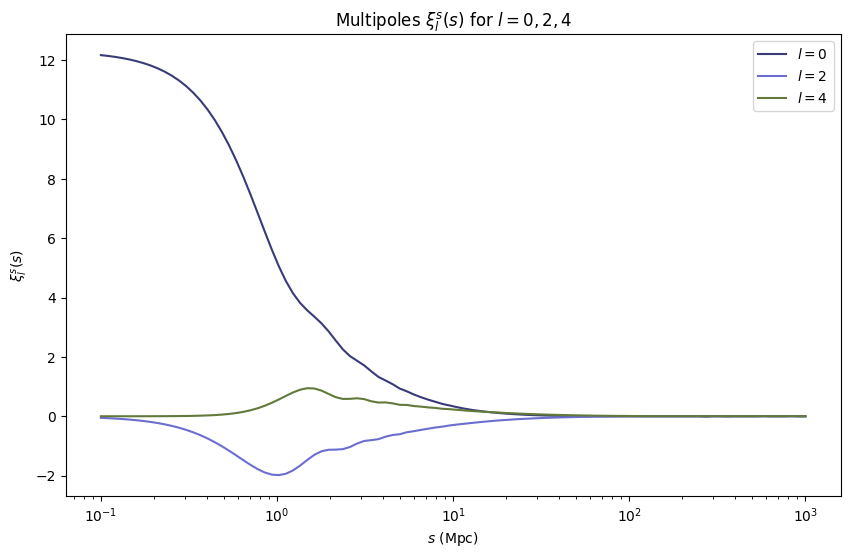

In [113]:
plt.figure(figsize=(10, 6))
cmap = plt.cm.get_cmap('tab20b')
for i, l in enumerate(l_values):
    plt.semilogx(s_values, xi_values[l], label=f'$l=${l}', color=cmap(2*i))
plt.xlabel('$s$ (Mpc)')
plt.ylabel(r'$\xi^s_l(s)$')
plt.legend()
plt.title(r'Multipoles $\xi^s_l(s)$ for $l = 0, 2, 4$')
plt.savefig('multipoles.png', dpi=240)
plt.show()

In [114]:
Omega_m, Omega_DE = 0.3, 0.7
z_values = np.logspace(-2, 3, 100)

a_values = 1 / (1 + z_values)
f_values = np.array([f_z(a, Omega_m, Omega_DE) for a in a_values])
beta_values = f_values # b = 1
cl_values = {l: np.array([c_l(beta, l) for beta in beta_values]) for l in [0, 2, 4]}

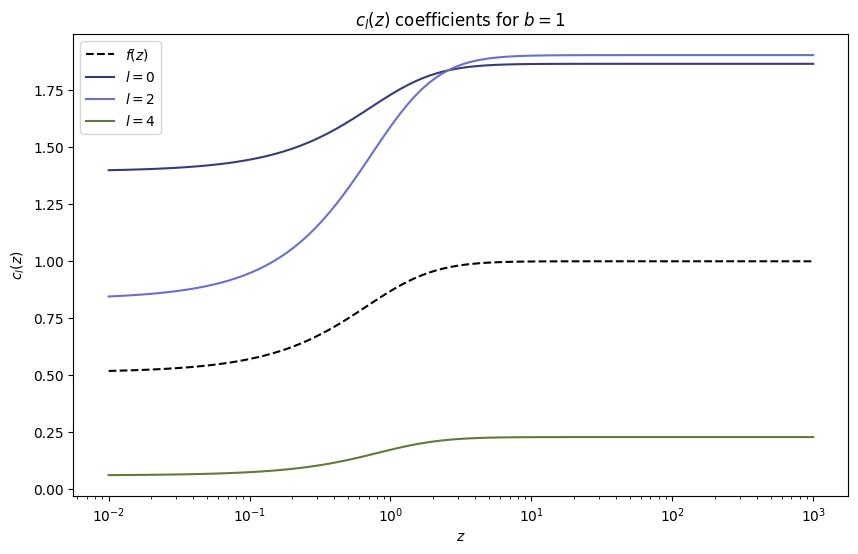

In [115]:
plt.figure(figsize=(10, 6))
plt.semilogx(z_values, f_values, label=r'$f(z)$', color='black', linestyle='--')
for i, l in enumerate(l_values):
    plt.semilogx(z_values, cl_values[l], label=rf'$l={l}$', color=cmap(2*i))
plt.xlabel(r'$z$')
plt.ylabel(r'$c_l(z)$')
plt.title(r'$c_l(z)$ coefficients for $b=1$')
plt.legend()
plt.savefig('cl_values.png', dpi=240)
plt.show()

In [116]:
x = np.linspace(-20, 20, 100) # s perpendicular
y = np.linspace(-20, 20, 100) # s parallel
X, Y = np.meshgrid(x, y)
s_values = np.sqrt(X**2 + Y**2)
for i in range(len(s_values)):
    for j in range(len(s_values[i])):
        if s_values[i][j] == 0:
            s_values[i][j] = 1e-15
mu = 0 / s_values # cos(theta)

xi_g_values = xi_g(s_values, xi_values, mu, [0, 2, 4])

for i in range(len(xi_g_values)):
    for j in range(len(xi_g_values[i])):
        if xi_g_values[i][j] == 0:
            xi_g_values[i][j] = 1e-15

log10_xi_g_values = np.log10(xi_g_values)
log10_xi_g_values = np.clip(log10_xi_g_values, -2.4, 2.4)

/tmp/ipykernel_9721/1502210473.py:18: RuntimeWarning: invalid value encountered in log10
  log10_xi_g_values = np.log10(xi_g_values)


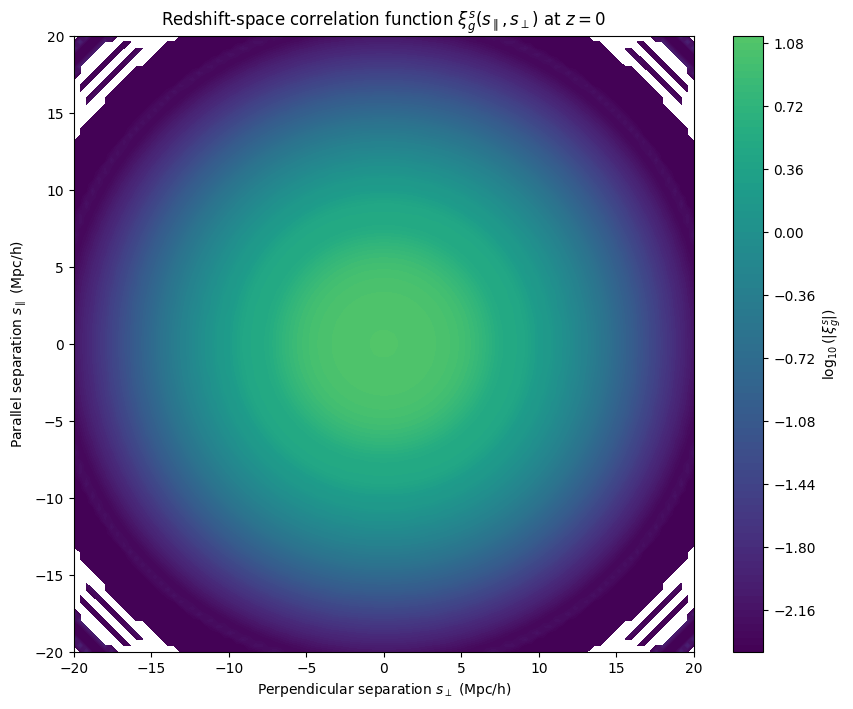

In [117]:
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, log10_xi_g_values, levels=100, cmap='viridis', vmin=-2.4, vmax=2.4)
plt.colorbar(label=r'$\log_{10}(|\xi_g^s|)$')
plt.xlabel(r'Perpendicular separation $s_\perp$ (Mpc/h)')
plt.ylabel(r'Parallel separation $s_\parallel$ (Mpc/h)')
plt.title(r'Redshift-space correlation function $\xi_g^s(s_\parallel, s_\perp)$ at $z=0$')
plt.savefig('correlation_function.png', dpi=240)
plt.show()

In [118]:
x = np.linspace(-20, 20, 100) # s perpendicular
y = np.linspace(-20, 20, 100) # s parallel
X, Y = np.meshgrid(x, y)
s_values = np.sqrt(X**2 + Y**2)
for i in range(len(s_values)):
    for j in range(len(s_values[i])):
        if s_values[i][j] == 0:
            s_values[i][j] = 1e-15
mu = 0 / s_values # cos(theta)

xi_g_values = xi_g(s_values, xi_values, mu, [0])

for i in range(len(xi_g_values)):
    for j in range(len(xi_g_values[i])):
        if xi_g_values[i][j] == 0:
            xi_g_values[i][j] = 1e-15

log10_xi_g_values = np.log10(xi_g_values)
log10_xi_g_values = np.clip(log10_xi_g_values, -2.4, 2.4)

/tmp/ipykernel_9721/915735638.py:18: RuntimeWarning: invalid value encountered in log10
  log10_xi_g_values = np.log10(xi_g_values)


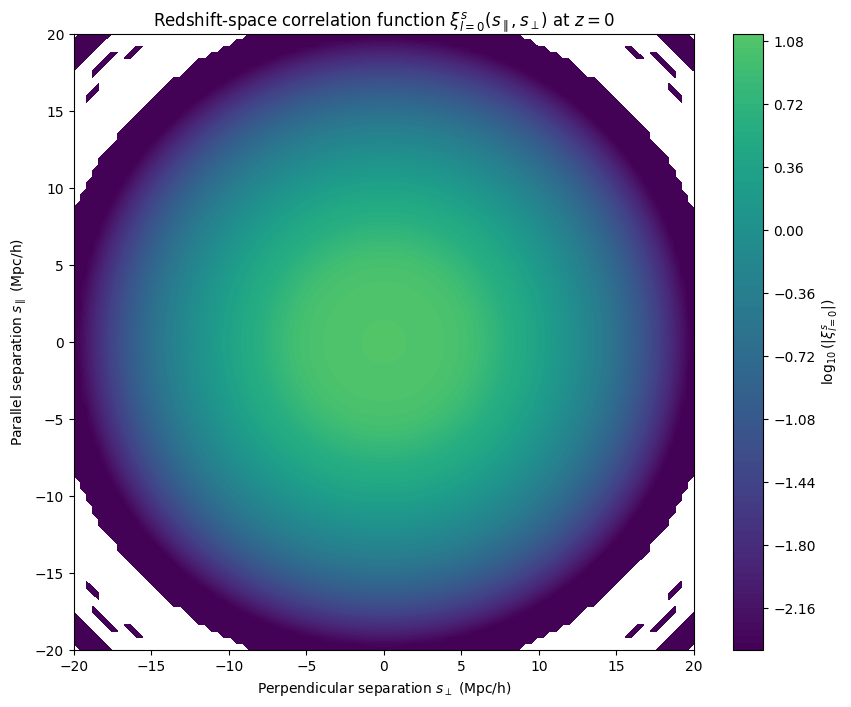

In [119]:
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, log10_xi_g_values, levels=100, cmap='viridis', vmin=-2.4, vmax=2.4)
plt.colorbar(label=r'$\log_{10}(|\xi_{l=0}^s|)$')
plt.xlabel(r'Perpendicular separation $s_\perp$ (Mpc/h)')
plt.ylabel(r'Parallel separation $s_\parallel$ (Mpc/h)')
plt.title(r'Redshift-space correlation function $\xi_{l=0}^s(s_\parallel, s_\perp)$ at $z=0$')
plt.savefig('correlation_function_l0.png', dpi=240)
plt.show()